# Dependencies

In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Connect to SQLite engine

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

# Use Automap to reflect tables into classes

In [4]:
Base = automap_base()

In [5]:
Base.prepare(engine,reflect=True)

In [6]:
Base.classes.keys()

['measurements', 'stations']

In [7]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

# Track Precipitation over past year

In [8]:
# Create session and precipitation query
session = Session(engine)
precipitation = session.query(Measurements.date,Measurements.prcp)

# Create Dataframe and group by Date
precip_df = pd.read_sql(precipitation.statement, precipitation.session.bind)
by_date = precip_df.groupby(["date"]).sum()

In [9]:
# Grab tail 365 entries for look at most recent year
last_year = by_date.tail(365)
last_year.reset_index(inplace=True,drop=False)
last_year.head()

,date,prcp
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10


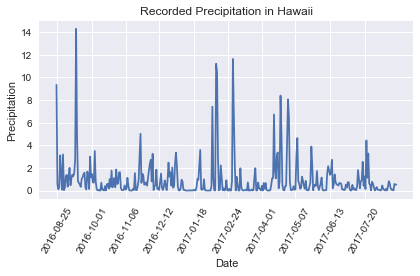

In [10]:
# Plot graph
sns.set()
plt.plot(last_year["prcp"],label="Precipitation")

plt.title("Recorded Precipitation in Hawaii")
plt.xlabel("Date")
plt.ylabel("Precipitation")

# Set 10 x-ticks and pull date for label
total = len(last_year["prcp"])
x_ticks = np.arange(1,total,(total/10),dtype=Integer)
x_ticks = [round(x) for x in x_ticks]
labels = [last_year["date"][x] for x in x_ticks]
plt.xticks(x_ticks, labels, rotation=60)

plt.tight_layout()
plt.savefig("lastyear_prcp.pdf")
plt.show()

# Find Temperature Frequencies for past year

In [11]:
# List stations by amount of readings
station_activity = session.query(Measurements.station)
activity_df = pd.read_sql(station_activity.statement, station_activity.session.bind)
activity_df = pd.DataFrame(activity_df["station"].value_counts())
activity_df

,station
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [12]:
# Find the frequency of TOBS readings in the past year
# At the station with the most readings (USC00519281)
tobs = session.query(Measurements.station,Measurements.date,Measurements.tobs)
tobs_df = pd.read_sql(tobs.statement, tobs.session.bind)

waihee = tobs_df.loc[tobs_df["station"]=="USC00519281"]
waihee_lastyr = waihee.tail(365)
waihee_lastyr.head()

,station,date,tobs
13322,USC00519281,2016-08-10,82
13323,USC00519281,2016-08-11,80
13324,USC00519281,2016-08-12,76
13325,USC00519281,2016-08-13,80
13326,USC00519281,2016-08-14,76


In [13]:
# Sort value counts of TOBS readings by the temperature read
tobs_counts = pd.DataFrame(waihee_lastyr["tobs"].value_counts())
tobs_counts.sort_index(inplace=True)
tobs_counts.reset_index(inplace=True,drop=False)
tobs_counts.columns = ['tobs', 'count']
tobs_counts.set_index("tobs",inplace=True)
tobs_counts.head()

,count
tobs,
59,3
60,2
61,1
62,6
63,4


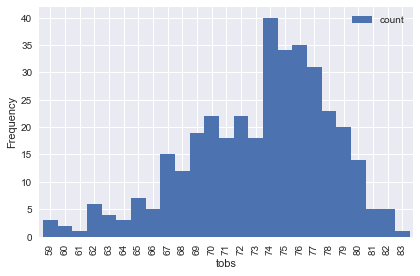

In [14]:
# I was unable to get an accurate plot with '.hist' but this bar chart
# appears to be the same information requested from the histogram
tobs_counts.plot.bar(width=1)

plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("tobs_frequency.pdf")
plt.show()

# Create function to Calculate Temperature

In [15]:
def calc_temps():
    # Start the query and create a dataframe
    query = session.query(Measurements.date, Measurements.tobs)
    dataframe = pd.read_sql(query.statement, query.session.bind)
    
    # Collect dates from user
    year = input("Enter the 4-digit year of your trip: ")
    start_date = input("Enter the date of your departure (MM-DD): ")
    end_date = input("Enter the date of your return (MM-DD): ")
    
    # Set start_date and end_date variables
    start_year = str(int(year) - 1)
    start_date = start_year + "-" + start_date
    end_date = start_year + "-" + end_date
    
    # Trim dataframe to selected dates
    trimmed = dataframe.loc[dataframe["date"] >= start_date]
    trimmed = dataframe.loc[dataframe["date"] <= end_date]
    
    # Group by Date
    avg_temp = trimmed.groupby("date").mean()
    
    # Set Min and Max temp variables / Calculate Y-Error
    min_temp = avg_temp["tobs"].min()
    max_temp = avg_temp["tobs"].max()
    error = max_temp - min_temp
    
    # Calculate Average Temp and create single Dataframe
    avg_temp = avg_temp["tobs"].mean()
    avg_temp = pd.DataFrame([{"Temperature":avg_temp}])
    
    # Plot the Bar Graph
    avg_temp.plot.bar(yerr=error,color='orange',alpha=0.5,width=.25)
    plt.title("Average Temp during Time of Trip (Previous Year)")
    plt.ylabel("Temperature (F)")
    plt.tight_layout()
    plt.savefig("avg_trip_temp.pdf")
    plt.show()

Enter the 4-digit year of your trip: 2017
Enter the date of your departure (MM-DD): 08-03
Enter the date of your return (MM-DD): 08-21


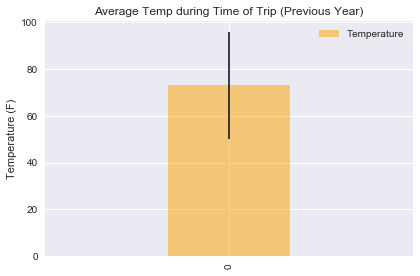

In [147]:
calc_temps()